In [ ]:
from pathlib import Path
import requests

    1. Path and request module are used for fetching data from src.
    2. The data is a zip file which contains the MNIST dataset in
       pickle format.
    3. Pickle format is used for serializing data(binary stream)
       objects in python.

In [ ]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir( parents=True, exist_ok = True )

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():

    content = requests.get(URL+FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

Here we use gzip and pickle module to unzip and access the dataset.

In [ ]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(),"rb") as f:
        ((x_train,y_train) ,(x_valid,y_valid),_) = pickle.load(f,
            encoding= "latin-1")


    1. The dataset are pixels of images but they are stored as a
       flattened single vector or array with 784(28*28) columns or
       entries. 
    2. Inorder to plot the image we need to reshape it to 2D.
    3. There are 50,000 images or instances.

(50000, 784)


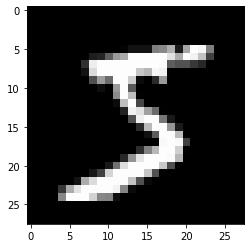

In [ ]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape(28,28),cmap = "gray")
print(x_train.shape)

1. PyTorch works on torch.tensor data-objects but our data is an
   array. Hence we need to construct tensor object from our dataset.
2. Torch.tensor is a module which does this,  hence we use map and
   (tensor module & corresponding array objects) to replace the array
   storing variables with tensor objects. 

In [ ]:
import torch

x_train , Y_train , x_valid , y_valid = map(
        torch.tensor , (x_train,y_train,x_valid,y_valid)
)
n,c = x_train.shape

print(x_train,y_train)
print(x_train.shape)
print(y_train.min(),y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) [5 0 4 ... 8 4 8]
torch.Size([50000, 784])
0 9


### Model (with tensor operations)

In [ ]:
import math

weights = torch.randn(784,10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10,requires_grad= True)

In [ ]:
def log_softmax(x):
    print(x)
    return x - x.exp().sum().log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [ ]:
bs = 64

xb = x_train[0:bs]
preds = model(xb)
preds[0] , preds.shape
print(preds[0],preds.shape)

tensor([[ 0.3491,  0.2689,  0.1986, -0.0216, -0.3100, -0.3220,  0.3167, -0.2032,
          0.2006, -0.1772],
        [ 0.2745,  0.5444,  0.2706,  0.0593, -0.2628, -0.6475, -0.1728, -0.0886,
         -0.3560, -0.1570],
        [ 0.0825, -0.0705,  0.2043, -0.0310, -0.2172, -0.0914, -0.0654,  0.1234,
          0.9127, -0.1294],
        [ 0.1605,  0.2513,  0.2777,  0.2376, -0.1715,  0.2589,  0.2378,  0.1860,
          0.3937, -0.0804],
        [ 0.5712,  0.2126,  1.0248,  0.2692, -0.4475, -0.3661,  0.1577,  0.0239,
          0.1573, -0.1259],
        [ 0.1578,  0.1195,  1.0611,  0.3050, -0.0627,  0.2119, -0.0161, -0.0683,
          0.8610,  0.3500],
        [ 0.3297,  0.2145,  0.4115, -0.0864, -0.0514,  0.1353,  0.0287,  0.1513,
          0.1402, -0.3990],
        [ 0.7073,  0.3515,  0.8983,  0.0453, -0.0246, -0.2049,  0.4074,  0.2853,
          0.3401, -0.0520],
        [ 0.3199,  0.2306,  0.2530, -0.0689,  0.0034, -0.0186, -0.0418,  0.1160,
         -0.1326, -0.5100],
        [ 0.0919,  

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1b0fc471-afe9-40dd-afe8-89e46e68c6e6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>